In [1]:
pip install tensorflow librosa matplotlib


# 1. Train Model

In [2]:
# Install dependencies
!pip install librosa soundfile --quiet

# Import libraries
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Configuration
DATA_DIR = "/content/drive/MyDrive/dataset_1"
KEYWORDS = ["bed", "bird", "cat", "dog", "house"]
SAMPLE_RATE = 16000
DURATION = 1  # seconds
SAMPLES = SAMPLE_RATE * DURATION
N_MELS = 40
TEST_SAMPLES_PER_CLASS = 50

# Validate dataset
for keyword in KEYWORDS:
    path = os.path.join(DATA_DIR, keyword)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing folder: {path}")
    num_files = len([f for f in os.listdir(path) if f.endswith(".wav")])
    print(f"{keyword}: {num_files} samples")

# Feature extraction
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    if len(y) < SAMPLES:
        y = np.pad(y, (0, SAMPLES - len(y)))
    else:
        y = y[:SAMPLES]
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    return librosa.power_to_db(mel, ref=np.max)

# Load data
X, y = [], []
for label_idx, keyword in enumerate(KEYWORDS):
    files = os.listdir(os.path.join(DATA_DIR, keyword))
    for file in files:
        if file.endswith('.wav'):
            filepath = os.path.join(DATA_DIR, keyword, file)
            features = extract_features(filepath)
            X.append(features)
            y.append(label_idx)

X = np.array(X)[..., np.newaxis]
y = np.array(y)

# Train-test split
test_size = (TEST_SAMPLES_PER_CLASS * len(KEYWORDS)) / len(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

# Define model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=X.shape[1:]),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(KEYWORDS), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)


bed: 2014 samples
bird: 2064 samples
cat: 2031 samples
dog: 2128 samples
house: 2113 samples


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5431 - loss: 1.5989 - val_accuracy: 0.8600 - val_loss: 0.3801
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8982 - loss: 0.2990 - val_accuracy: 0.9080 - val_loss: 0.2964
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9290 - loss: 0.2141 - val_accuracy: 0.9040 - val_loss: 0.2771
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9456 - loss: 0.1614 - val_accuracy: 0.9280 - val_loss: 0.1817
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9498 - loss: 0.1343 - val_accuracy: 0.9400 - val_loss: 0.1892
Epoch 6/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9682 - loss: 0.0919 - val_accuracy: 0.9440 - val_loss: 0.1578
Epoch 7/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9744 - loss: 0.0765 - val_accuracy: 0.9320 - val_loss: 0.1743
Epoch 8/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9750 - loss: 0.0719 - val_accuracy: 0.

# 2. Evaluate Model

✅ Test Accuracy: 0.9240
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
🔍 Classification Report:
              precision    recall  f1-score   support

         bed       0.84      0.98      0.91        49
        bird       0.91      0.86      0.89        50
         cat       0.98      0.86      0.91        49
         dog       0.94      0.96      0.95        51
       house       0.96      0.96      0.96        51

    accuracy                           0.92       250
   macro avg       0.93      0.92      0.92       250
weighted avg       0.93      0.92      0.92       250



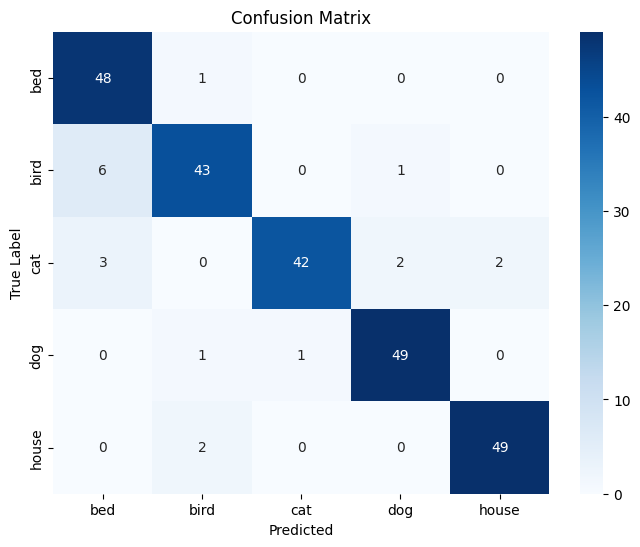

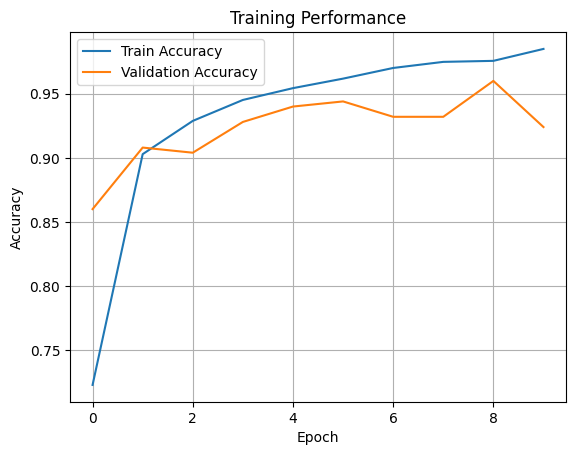

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate accuracy
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc:.4f}")

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=KEYWORDS))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=KEYWORDS, yticklabels=KEYWORDS, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Visualize training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training Performance")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# 3. Convert to TFLite

In [ ]:
# Convert to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save model
with open("keyword_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved as 'keyword_model.tflite'")
